#Functions that need to be run first

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors

def build_second_order_matrix(transitions):
    """
    This function builds two 3d matrices. These matrices are made for storing
    the output of two second-order markov chains

    One markov chain calculates the total number of times
    a certain transition occurs in a sleep sequence (e.g. Wake -> Wake -> NREM),
    this matrix will later be used for the transition probabilities.


    The other matrix contains the average number of times a certain transition
    occurs. This will be used as a kind of control for the probabilities

    arguments:
    transitions: dataframe containing the sleep sequences scored under one of
    three treatments, RGS or CBD or a control

    returns:
    M: 3d matrix containing the total number of times a transition occurs in the
    sleep sequences
    state_index: dictionary containing the indexes of the states
    (for zero-based indexing)
    average_transitions: 3d matrix containing the average number of times a
    transition occurs in the sleep sequences
    """
    # Set of unique states
    unique_states = set(state for sequence in transitions for state in sequence)

    # Set the number of unique states
    n = len(unique_states)

    # Loops through each unique state, retrieves its index,
    # and stores it in a dictionary (e.g., {1: 0, 2: 1, 3: 2, etc.})
    state_index = {state: index for index, state in enumerate(sorted(unique_states))}

    # Obtains the amount of sequences used for the average matrix
    amount_sequences = len(transitions)

    # Initialze the 3D matrix filled with zeros: (prev1, prev2) → next_state
    # Shape: [n][n][n]
    M = [[[0 for _ in range(n)] for _ in range(n)] for _ in range(n)]

    # Loop through te sequences in the dataframe
    for sequence in transitions:

        # Iterates through the sequence and, in each loop, retrieves three sleep
        # states: two from previous time steps (previous state 1 and previous
        # state 2) and the next state. First two states don't get used as next
        # state
        for i in range(len(sequence) - 2):

            # Assigns variables to the different states: s1: previous state 1,
            # s2: previous state 2, s3: next state
            s1, s2, s3 = sequence[i], sequence[i+1], sequence[i+2]

            # Checks whether previous state 2 is equal to next state and skips
            # if true (N -> W -> W) doesn't get counted to avoid self
            # transitions
            if s1 == s2 or  s2 == s3:
              continue

            # Obtains the index for the 3d matrix based on the sleep states and
            # adds one to that specific index
            i1, i2, i3 = state_index[s1], state_index[s2], state_index[s3]
            M[i1][i2][i3] += 1

    # Initialize the 3D matrix of average transitions with zeros
    average_transitions = [[[0 for _ in range(n)] for _ in range(n)] for _ in range(n)]

    # loops through the number of unique states
    for i1 in range(n):
        for i2 in range(n):
            for i3 in range(n):

                # Calculate the average transition for the values in the index
                # of M[i1][i2][i3] and rounds down
                average_transitions[i1][i2][i3] = round(M[i1][i2][i3] / amount_sequences, 3)

    return M, state_index, average_transitions

def normalize_matrix(M):
    """
    This function normalizes the total number of times 3d matrix to turn it
    into probabilities.

    arguments:
    M: 3D matrix containing the total number of times a transition occured in
    all sleep sequences of the treatment (W -> N -> W)

    returns:
    M: 3D matrix containing the probabilities of a transition occuring in a
    sleep sequence
    """
    # Variale for the length of the 3d matrix
    n = len(M)

    # Iterates over the rows of the previous states, calculates the sum of each
    # row, and normalizes each value by dividing it by the total sum.
    for i in range(n):
        for j in range(n):
            total = sum(M[i][j])
            if total > 0:
                M[i][j] = [count / total for count in M[i][j]]

    return M

def print_normalized_matrix(M, state_index):
    """
    This function prints the 3D matrix like:
    From previous state 1 -> previous state 2:
      -> next state: probability

    arguments:
    M: 3D matrix containing the probabilities of certain sleep state transitions
    occuring in a sleep sequence
    state_index: # A dictionary where the states are the keys and their
    corresponding zero-based indices are the values.

    returns:
    The probabilities of the transitions that are printed in a nice way
    """
    # Creates a dictionary with the index as the keys and the state as the value
    # done to make the printing easier
    index_state = {index: state for state, index in state_index.items()}
    n = len(state_index)

    # Iterates through the previous states, using them as context for the transitions.
    # It retrieves the next state and its probability, then prints the context followed
    # by the next state and its corresponding probability.
    for i in range(n):
        for j in range(n):
            context = (index_state[i], index_state[j])
            transitions = [(index_state[k], round(M[i][j][k], 3)) for k in range(n) if M[i][j][k] > 0]
            if transitions:
                print(f"From {context[0]} → {context[1]}:")
                for target, prob in transitions:
                    print(f"  → {target}: {prob}")

def visualize_flat_heatmap(M, state_index, title, state_label_map):
    """
    This functions visualizes the 3D probability matrix into a heatmap

    arguments:
    M: 3D matrix containing the transition probabilities
    state_index: dictionary containing the index of the states
    title: string with the title of the heatmap
    state_label_map: dictionary with the number of the sleep state as the key
    and the abbreviation of the state as the value (1: W, 2: N, ect)

    returns:
    An heatmap showing the transition probabilities
    """
    # Reverse the state_index mapping to map states to numeric values
    index_state = {v: state_label_map.get(k, k) for k, v in state_index.items()}

    # Get the length of the matrix
    n = len(M)

    # Set the colors for the color map
    colors = ["#FFEBEB", "#C74B4B"]

    # Create a 2D matrix: rows = state3, cols = (state1, state2). Now empty
    flat_matrix = np.zeros((n, n * n))
    column_labels = []

    # Loops through the first (i) and second state (j) of the matrix
    for i in range(n):
        for j in range(n):
            # Assignes each (i,j) pair a unique 1D column index (column becomes
            # a 1D list) and add the labels of the columns to the column_labels
            # list. Assignes each (i,j) pair a unique 1D column index
            column_index = i * n + j
            column_labels.append(f"({index_state[i]}→{index_state[j]})")

            # Loop through the third state (next state) and store the transition
            # probabilities (or counts) in the corresponding column, where the rows
            # represent the next state and the columns represent the pair of previous states.
            for k in range(n):
                flat_matrix[k][column_index] = M[i][j][k]


    # Plot the 2D matrix
    plt.figure(figsize=(max(13, n * 2), 6))
    ax = sns.heatmap(flat_matrix, annot=True, fmt=".2f", cmap=mcolors.LinearSegmentedColormap.from_list("custom", colors),
                xticklabels=column_labels,
                yticklabels=[index_state[k] for k in range(n)],
                annot_kws={"size": 10},
                linewidth=.5)

    plt.xlabel("(prev1 → prev2)")
    plt.ylabel("Next State")
    plt.title(title)
    plt.xticks(rotation=60, fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

def visualize_difference_heatmap(M1, M2, state_index, title, state_label_map):
    """
    This function calculates the differences between two 3D matrices and
    turns it into a heatmap

    arguments:
    M1: The first 3D matrix. This gets used to reduce the second the matrix
    (M1 is always the control)
    M2: the second 3D matrix. This matrix gets reduced by the first matrix.
    (M2 is the matrix of a treatment)
    state_index: dictionary containing the index of the states
    title: the title of the heatmap
    state_label_map: dictionary with the number of the sleep state as the key
    and the abbreviation of the state as the value (1: W, 2: N, ect)

    returns:
    heatmap showing the differences between two 3D matrices
    """

    # Reverse the state_index mapping to map states to numeric values
    index_state = {v: state_label_map.get(k, k) for k, v in state_index.items()}

    # length of the index
    n = len(index_state)

    # Set colors for the colormap
    colors = ["#0000FF", "#FFFFFF", "#FF0000"]

    # Sets the labels to be the abbreviations of the states instead of the
    # numerical
    column_labels = [f"({index_state[i]}→{index_state[j]})" for i in range(n) for j in range(n)]
    row_labels = [index_state[k] for k in range(n)]

    # Create the difference matrix: shape (next_state, prev1→prev2)
    diff_matrix = np.zeros((n, n * n))

    # Loops through the first and second lists in the matrix
    for i in range(n):
        for j in range(n):
            # Assignes each (i,j) pair a unique 1D column index (column becomes
            # a 1D list)
            col_idx = i * n + j

            # Loop through the third state (k) and calculate the difference
            # between the corresponding values in the second and first matrices.
            # Store the result in the difference matrix.
            for k in range(n):
                diff_matrix[k][col_idx] = M2[i][j][k] - M1[i][j][k]

    # Plot heatmap with same layout as visualize_flat_heatmap
    plt.figure(figsize=(max(13, n * 2), 6))
    sns.heatmap(diff_matrix, annot=True, fmt=".2f", cmap=mcolors.LinearSegmentedColormap.from_list("custom", colors), center=0,
                xticklabels=column_labels,
                yticklabels=row_labels,
                annot_kws={"size": 10},
                linewidth=.5)


    plt.xlabel("(prev1 → prev2)")
    plt.ylabel("Next State")
    plt.title(title)
    plt.xticks(rotation=60, fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

#Phasic and Tonic second-order

Control:
Probability heatmap:


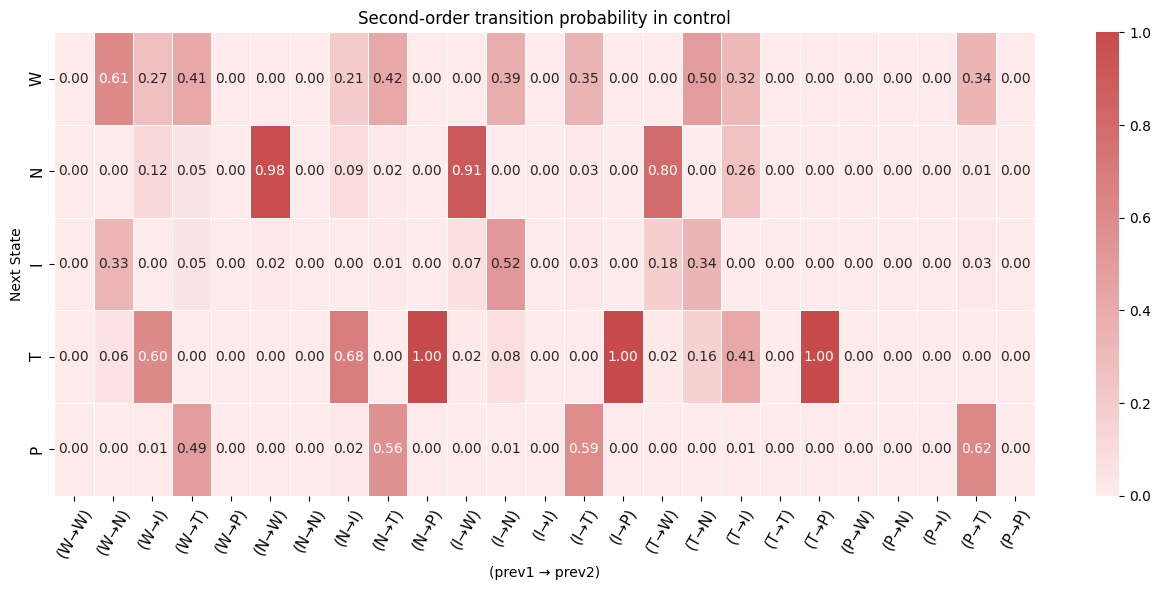


 Average transition occurrences heatmap:


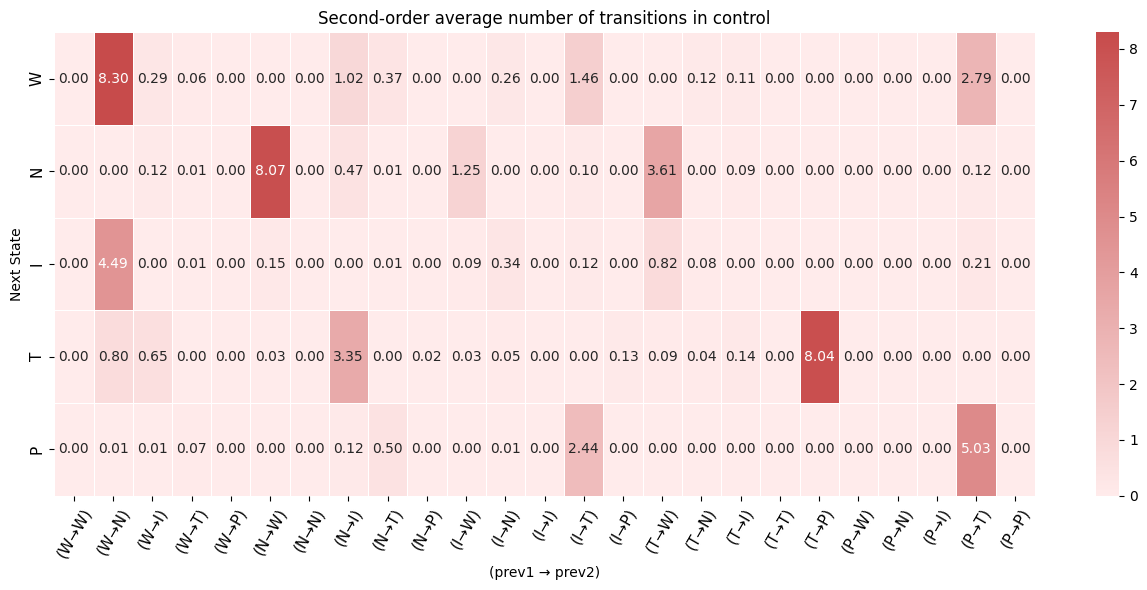



CBD:
Probability heatmap:


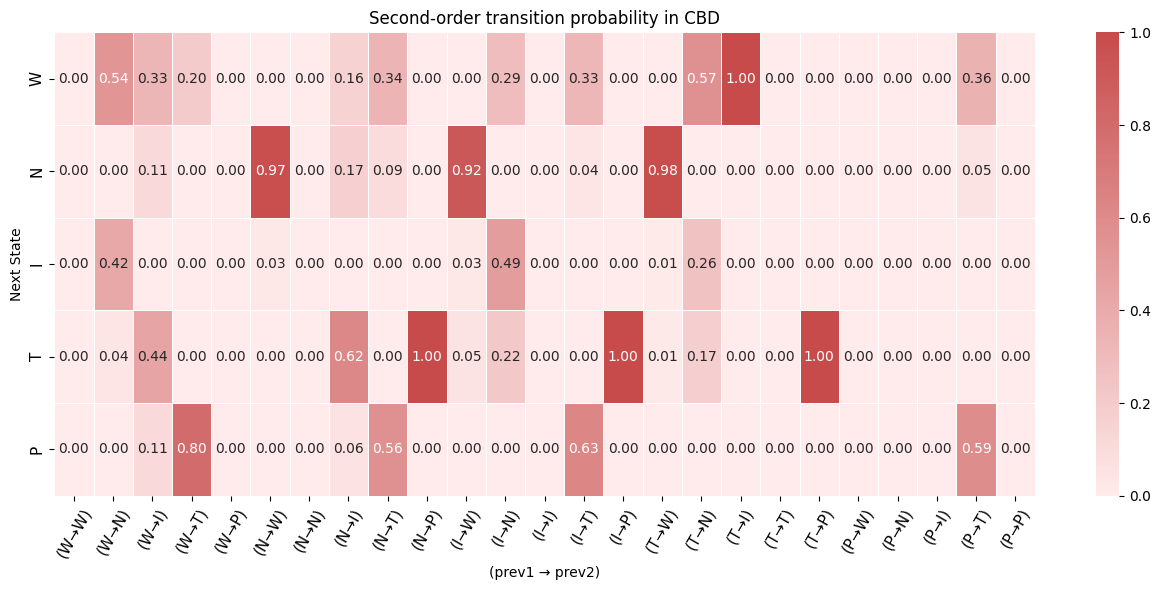


 Average transition occurrences heatmap


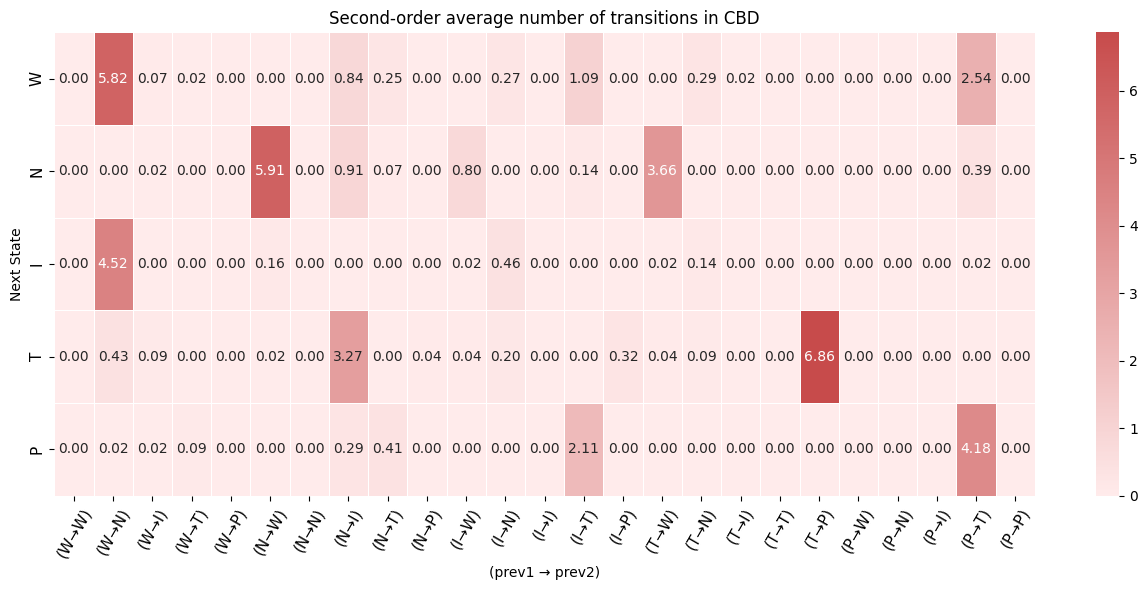



RGS:
Probability heatmap:


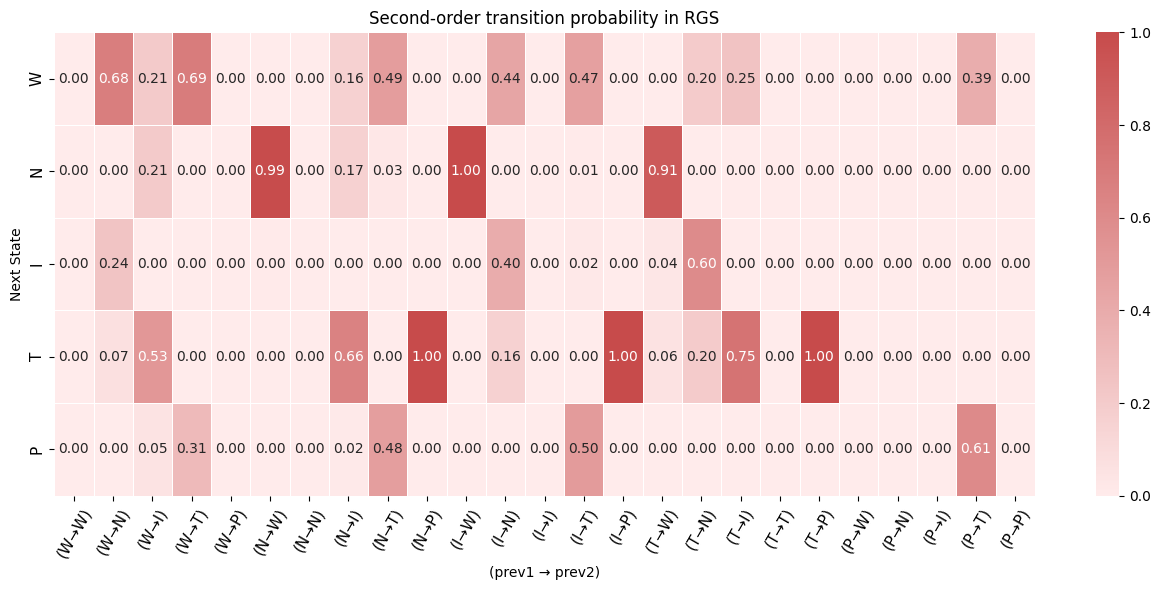


 Average transition occurrences heatmap:


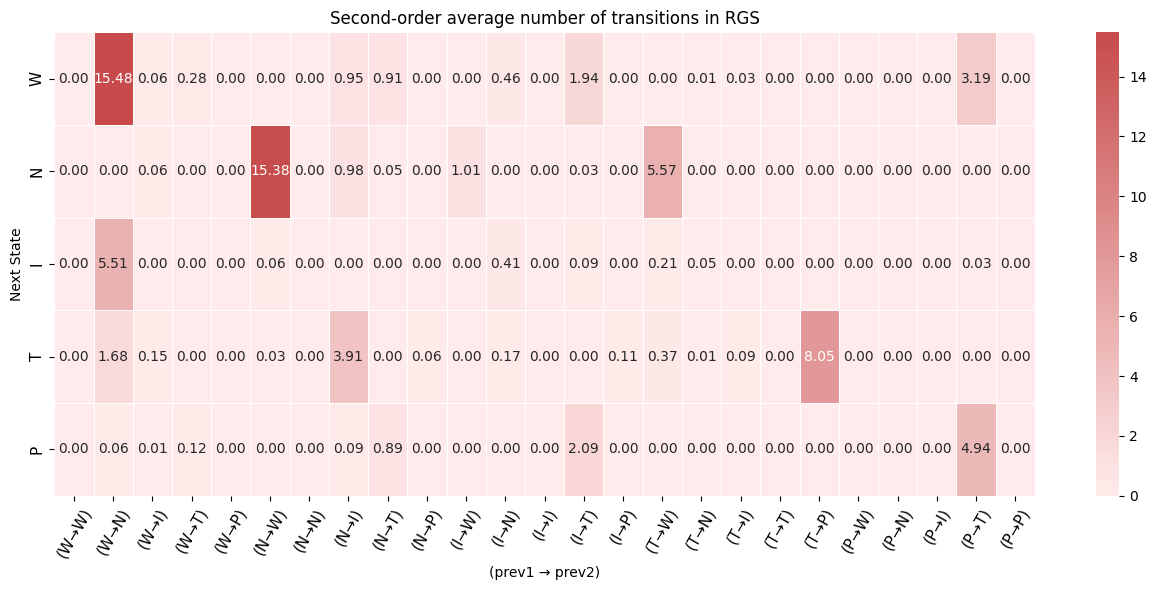



RGS - Control


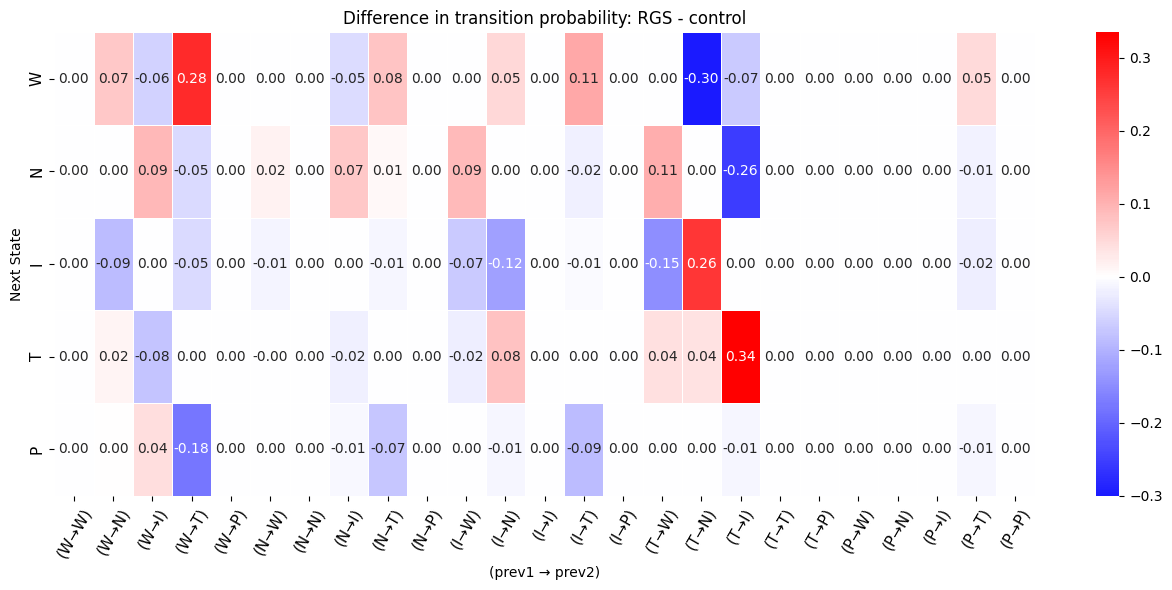

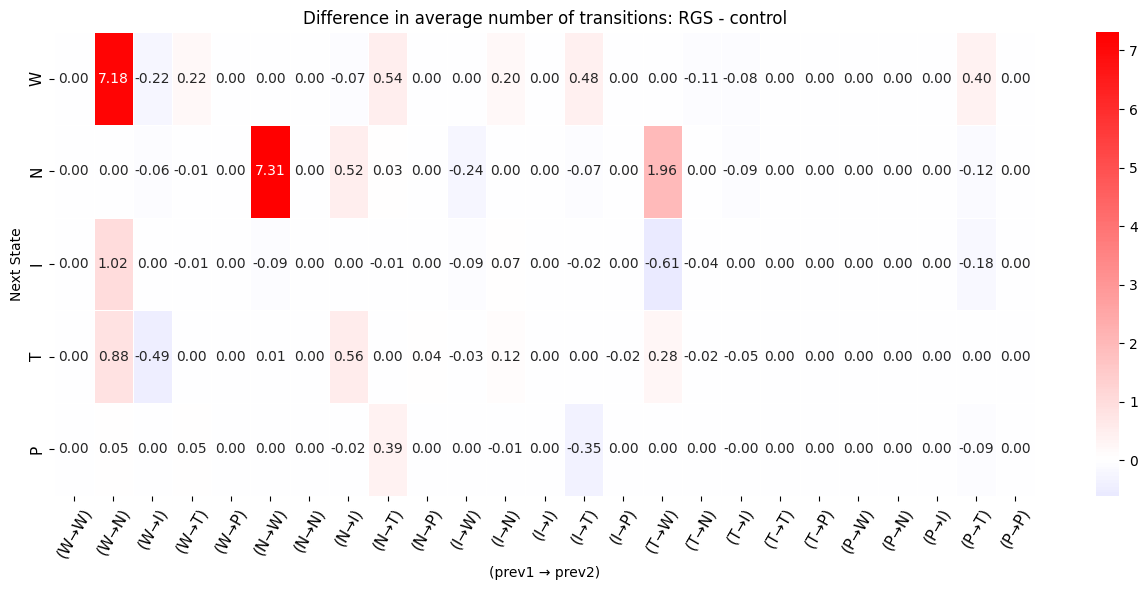



CBD - Control


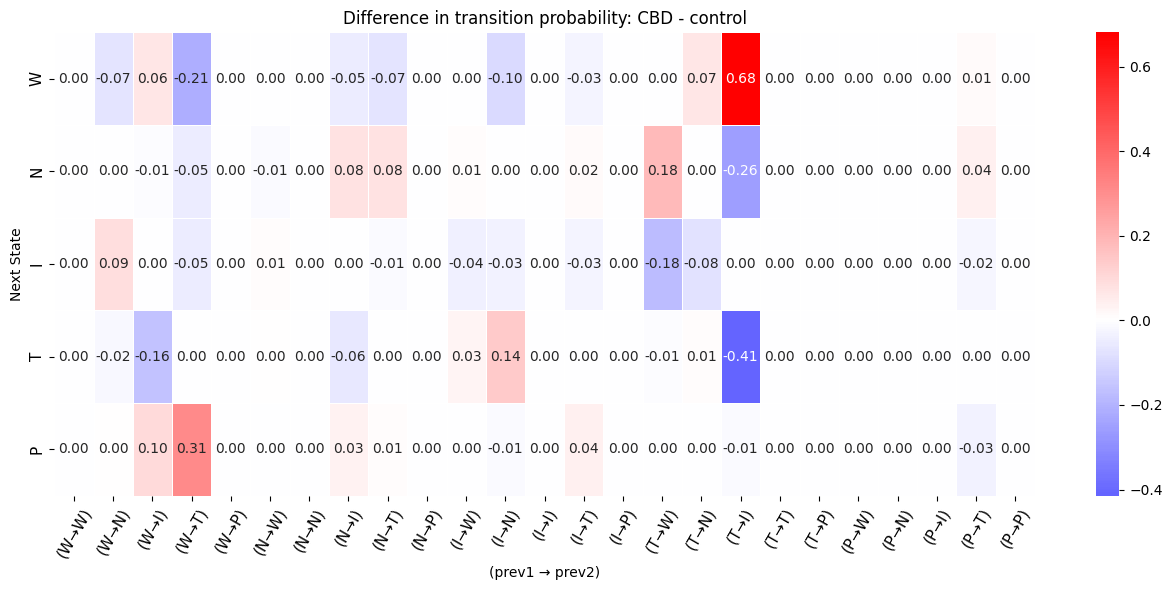

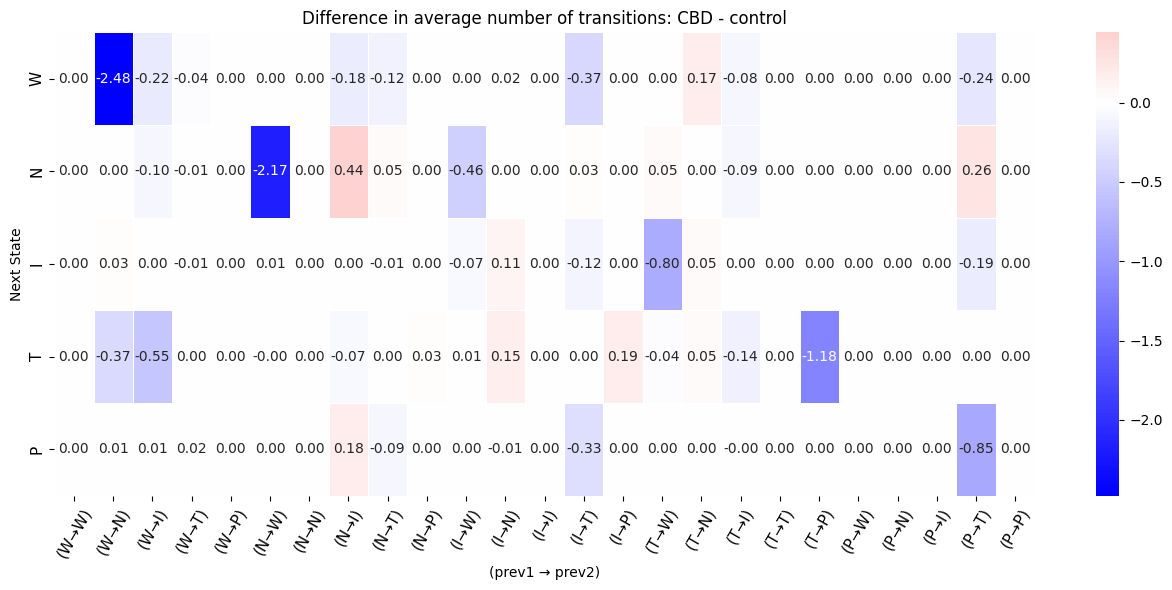

In [2]:
import pandas as pd  # Import pandas for data handling
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting


# Data processing
#-------------------------------------------------------------------------------
# Load drive
file_path = "/content/string_analysis_hypno_latencies_tonic_phasic.xlsx"
df = pd.read_excel(file_path, sheet_name="Feuil1")


# dictionary containing the number that are in the file as keys and the
# corresponding treatment as the values
treatments = {0: "Control", 1: "CBD", 2: "Control", 3: "RGS", 4: "Control"}

# Replaces the numerical values of the treatments with the names
for row in df["treatment"]:
    df["treatment"] = df["treatment"].replace(row, treatments.get(row))


# Creates a dataframe with only the treatments and the sleep sequences
# containing phasic and tonic
treatment_sequence_dataframe = df[["treatment", "string_phasic_tonic"]]

def convert_sequence(sequence):
    """
    Function that makes the state names into numbers and replaces _ with None in
    the sequences

    arguments:
    sequence: the sleep sequence containing the state abbreviations

    returns:
    numerical sleep sequence without any None values or consecutive states
    """
    # Checks if the current state is the same as the previous states, if so it
    # removes the current state and keeps the previous state
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]

    # Changes the state abbreviations into corresponding numbers
    return [1 if char == "W" else
            2 if char == "N" else
            3 if char == "I" else
            4 if char == "T" else
            5 if char == "P" else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]

# Makes subsets per treatment containing the sleep sequences with Phasic,
# Tonic and Intermediate states and remove None values created by the function
control_sequences = treatment_sequence_dataframe[treatment_sequence_dataframe["treatment"] == "Control"]["string_phasic_tonic"].apply(convert_sequence).apply(lambda seq: [value for value in seq if value is not None])
cbd_sequences = treatment_sequence_dataframe[treatment_sequence_dataframe["treatment"] == "CBD"]["string_phasic_tonic"].apply(convert_sequence).apply(lambda seq: [value for value in seq if value is not None])
RGS_sequences = treatment_sequence_dataframe[treatment_sequence_dataframe["treatment"] == "RGS"]["string_phasic_tonic"].apply(convert_sequence).apply(lambda seq: [value for value in seq if value is not None])

# Mapping the numeric states to the desired labels
state_label_map_phasic_tonic = {1: "W", 2: "N", 3: "I", 4: "T", 5: "P"}

# Control markov chain
#-------------------------------------------------------------------------------
print("Control:")
# Constructs the matrices: Total number and average number of transitions, then
# normalizes the total number matrix
M_control, Idx_map_control, average_M_control = build_second_order_matrix(control_sequences)
M_control = normalize_matrix(M_control)

# Uncomment for a nice print statment for the probability matrix
#print("normalized matrix:\n",print_normalized_matrix(M_control, Idx_map_control))

# Constructs heatmaps of the matrices
print("Probability heatmap:")
visualize_flat_heatmap(M_control, Idx_map_control, "Second-order transition probability in control", state_label_map_phasic_tonic)

print("\n", "Average transition occurrences heatmap:")
visualize_flat_heatmap(average_M_control, Idx_map_control, "Second-order average number of transitions in control", state_label_map_phasic_tonic)

print("\n")

# CBD markov chain
#-------------------------------------------------------------------------------

print("CBD:")
# Constructs the matrices: Total number and average number of transitions, then
# normalizes the total number matrix
M_cbd, Idx_map_cbd, average_M_cbd = build_second_order_matrix(cbd_sequences)
M_cbd = normalize_matrix(M_cbd)

# Uncomment for a nice print statment
#print(print_normalized_matrix(M_cbd, Idx_map_cbd))

# Constructs heatmaps of the matrices
print("Probability heatmap:")
visualize_flat_heatmap(M_cbd, Idx_map_cbd, "Second-order transition probability in CBD", state_label_map_phasic_tonic)

print("\n", "Average transition occurrences heatmap")
visualize_flat_heatmap(average_M_cbd, Idx_map_control, "Second-order average number of transitions in CBD", state_label_map_phasic_tonic)

print("\n")

# RGS markov chain
#-------------------------------------------------------------------------------
print("RGS:")
# Constructs the matrices: Total number and average number of transitions, then
# normalizes the total number matrix
M_rgs, Idx_map_rgs, average_M_rgs = build_second_order_matrix(RGS_sequences)
M_rgs = normalize_matrix(M_rgs)

# Uncomment for a nice print statment
#print(print_normalized_matrix(M_rgs, Idx_map_rgs))

# Constructs heatmaps of the matrices
print("Probability heatmap:")
visualize_flat_heatmap(M_rgs, Idx_map_rgs, "Second-order transition probability in RGS", state_label_map_phasic_tonic)

print("\n", "Average transition occurrences heatmap:")
visualize_flat_heatmap(average_M_rgs, Idx_map_control, "Second-order average number of transitions in RGS", state_label_map_phasic_tonic)

print("\n")


# Difference functions
#-------------------------------------------------------------------------------

# Constructs the difference heatmaps for RGS - Control
print("RGS - Control")
visualize_difference_heatmap(M_control, M_rgs, Idx_map_control, "Difference in transition probability: RGS - control", state_label_map_phasic_tonic)
visualize_difference_heatmap(average_M_control, average_M_rgs, Idx_map_control, "Difference in average number of transitions: RGS - control", state_label_map_phasic_tonic)

print("\n")


# Constructs the difference heatmaps for CBD - Control
print("CBD - Control")
visualize_difference_heatmap(M_control, M_cbd, Idx_map_control, "Difference in transition probability: CBD - control", state_label_map_phasic_tonic)
visualize_difference_heatmap(average_M_control, average_M_cbd, Idx_map_control, "Difference in average number of transitions: CBD - control", state_label_map_phasic_tonic)

#REM second-order

Control:
Probability heatmap:


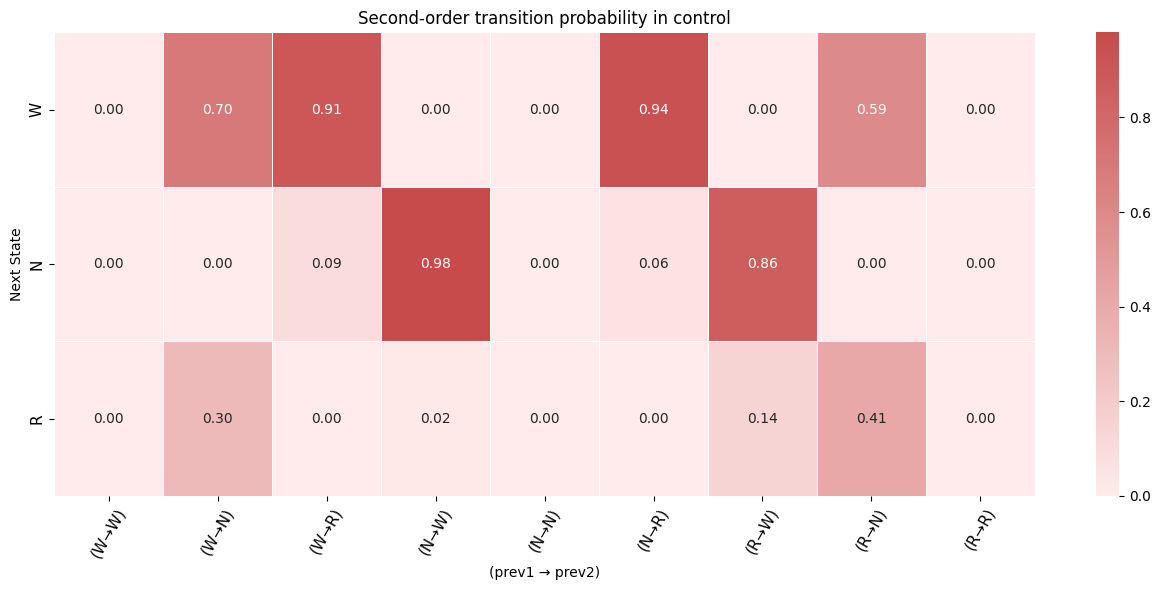


 Average transition occurrences heatmap:


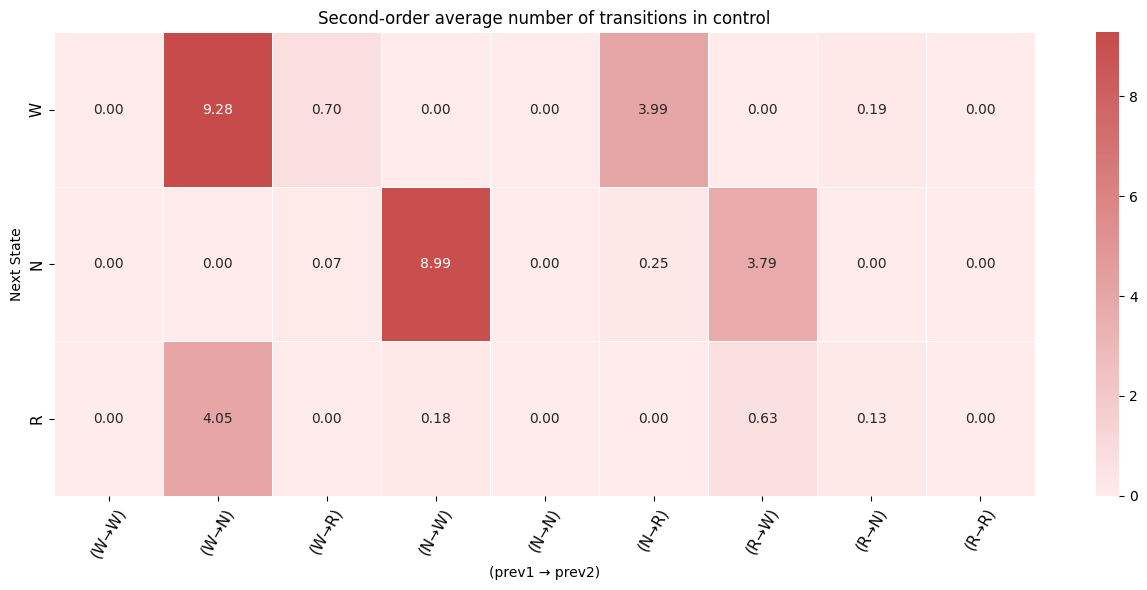



CBD:
Probability heatmap:


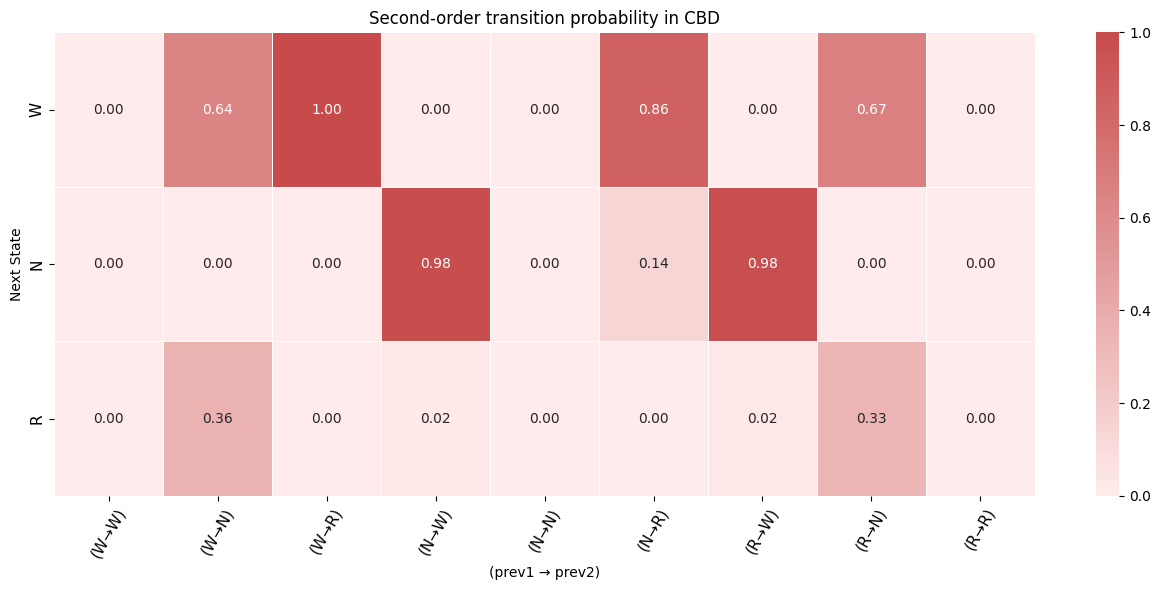


 Average transition occurrences heatmap


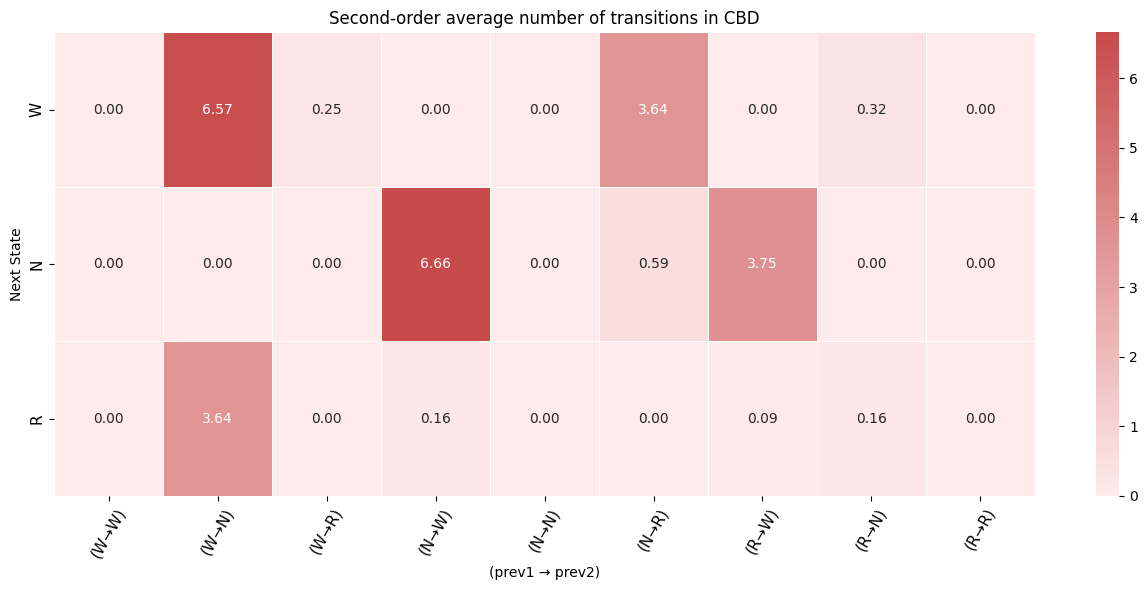



RGS:
Probability heatmap:


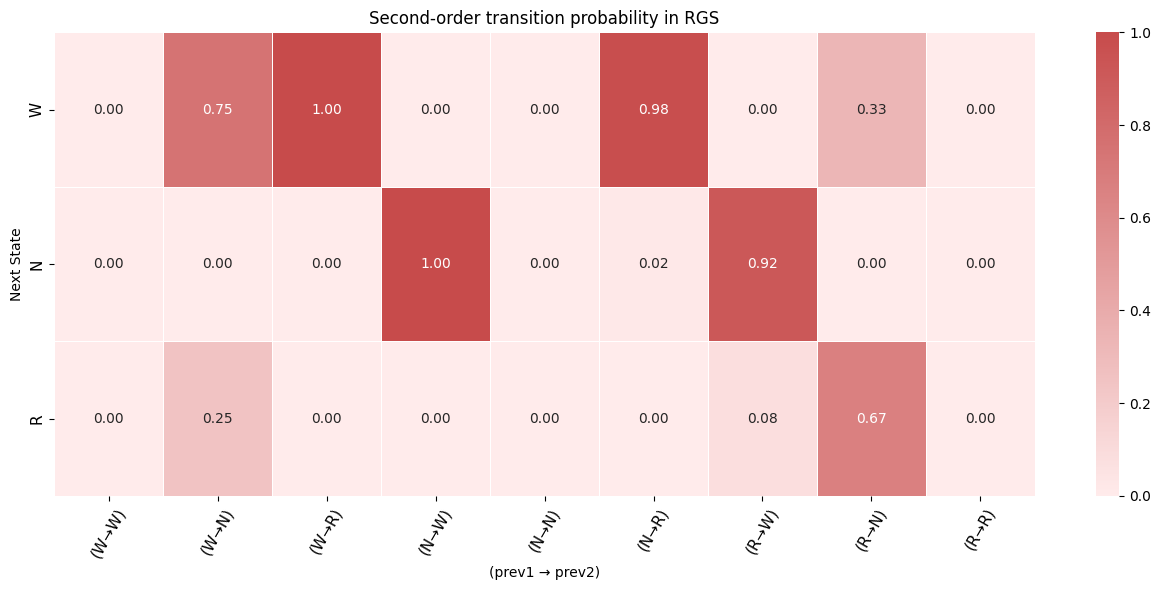


 Average transition occurrences heatmap:


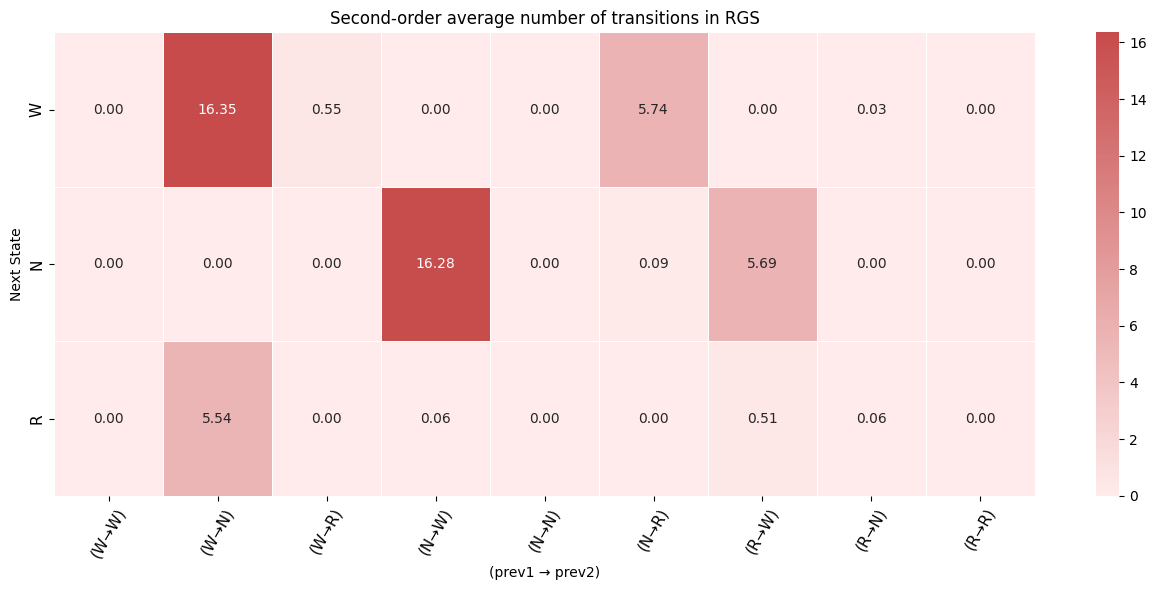



RGS - Control


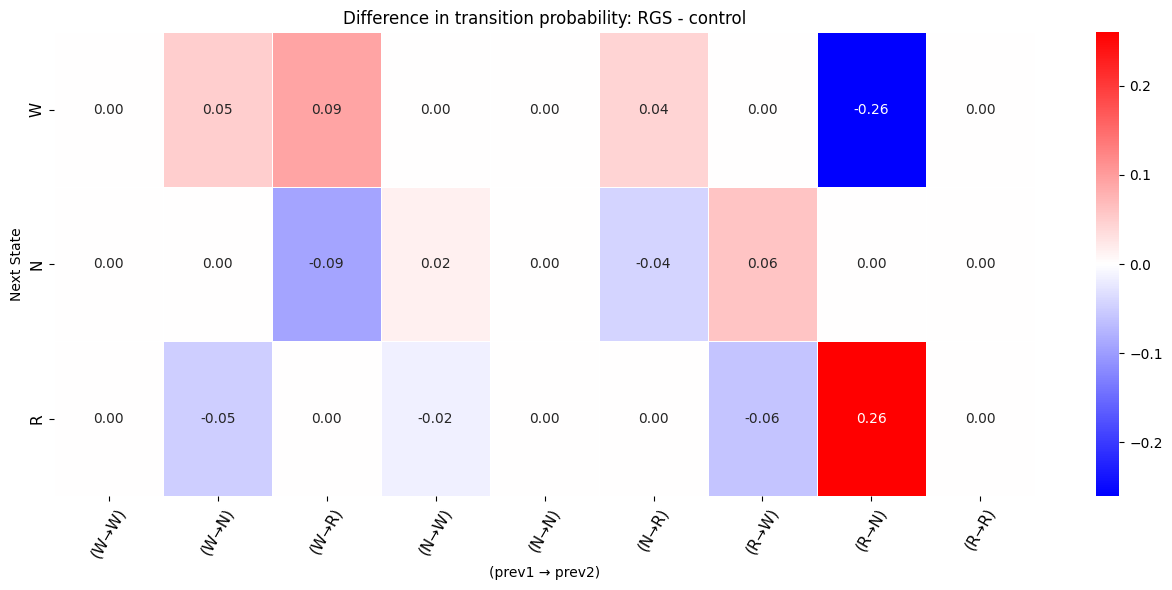

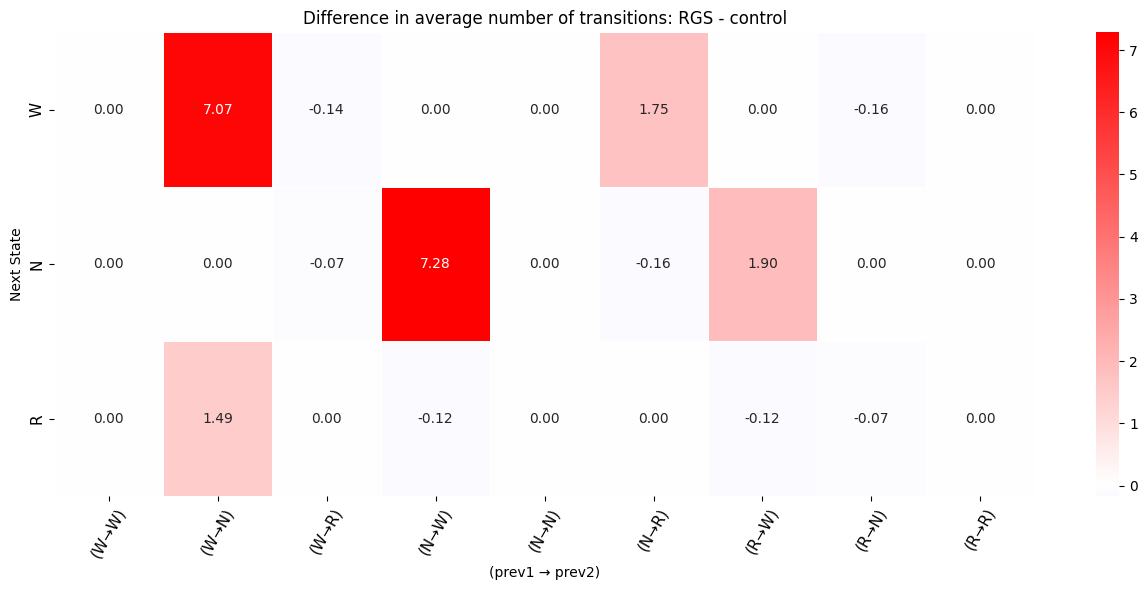



CBD - Control


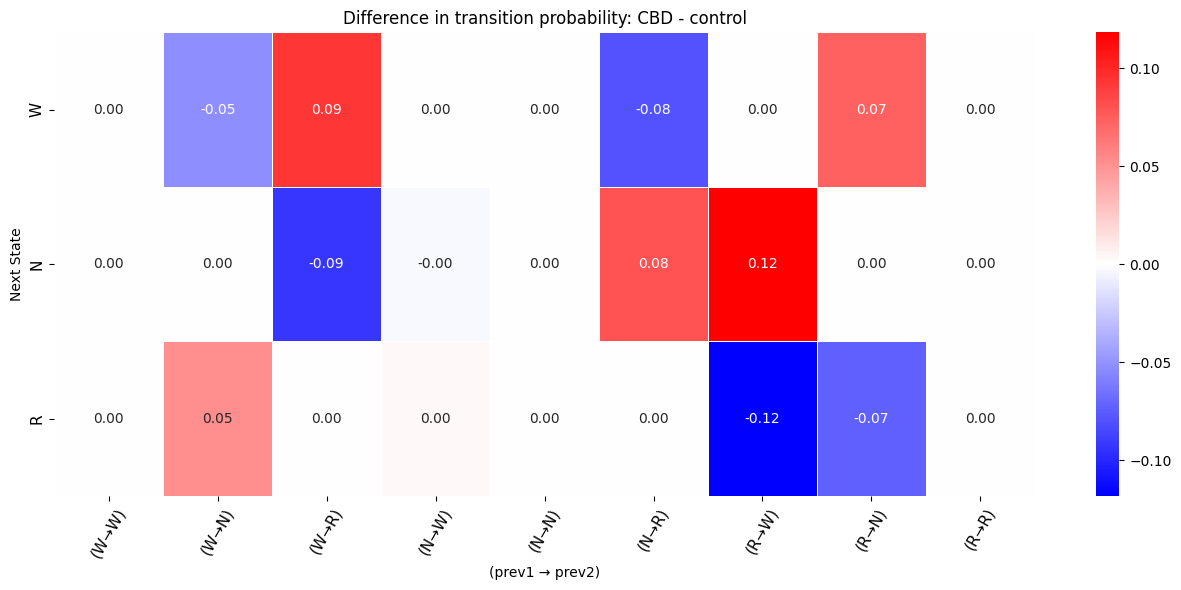

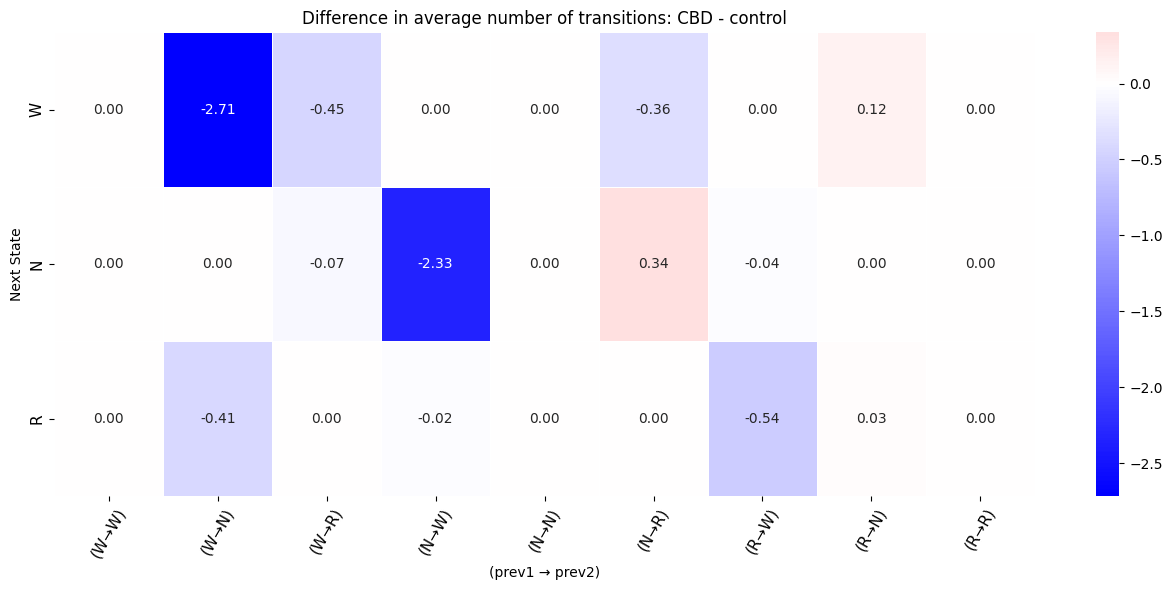

In [3]:

import pandas as pd  # Import pandas for data handling
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting


# Data processing
#-------------------------------------------------------------------------------
# Load drive
file_path = "/content/string_analysis_hypno_latencies_tonic_phasic.xlsx"
df = pd.read_excel(file_path, sheet_name="Feuil1")


# dictionary containing the number that are in the file as keys and the
# corresponding treatment as the values
treatments = {0: "Control", 1: "CBD", 2: "Control", 3: "RGS", 4: "Control"}

# Replaces the numerical values of the treatments with the names
for row in df["treatment"]:
    df["treatment"] = df["treatment"].replace(row, treatments.get(row))


# Creates a dataframe with only the treatments, trial_num and sleep sequences
treatment_sequence_dataframe = df[["treatment", "string_rem"]]


def convert_sequence(sequence):
    """
    Function that makes the state names into numbers

    arguments:
    sequence: the sleep sequence containing the state abbreviations

    returns:
    numerical sleep sequence without any None values or consecutive states
    """
    # Checks if the current state is the same as the previous states, if so it
    # removes the current state and keeps the previous state
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence = sequence # Comment to remove self transitions
    # Changes the state abbreviations into corresponding numbers
    return [1 if char == "W" else
            2 if char == "N" else
            3 if char == "R" else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            None for char in filtered_sequence]



# Makes subsets per treatment containing the sleep sequences with Phasic, Tonic and Intermediate
control_sequences = treatment_sequence_dataframe[treatment_sequence_dataframe["treatment"] == "Control"]["string_rem"].apply(convert_sequence).apply(lambda seq: [value for value in seq if value is not None])
cbd_sequences = treatment_sequence_dataframe[treatment_sequence_dataframe["treatment"] == "CBD"]["string_rem"].apply(convert_sequence).apply(lambda seq: [value for value in seq if value is not None])
RGS_sequences = treatment_sequence_dataframe[treatment_sequence_dataframe["treatment"] == "RGS"]["string_rem"].apply(convert_sequence).apply(lambda seq: [value for value in seq if value is not None])

# Mapping the numeric states to your desired labels
state_label_map_rem = {1: "W", 2: "N", 3: "R"}

# Control markov chain
#-------------------------------------------------------------------------------
print("Control:")
# Constructs the matrices: Total number and average number of transitions, then
# normalizes the total number matrix
M_control, Idx_map_control, average_M_control = build_second_order_matrix(control_sequences)
M_control = normalize_matrix(M_control)

# Uncomment for a nice print statment for the probability matrix
#print("normalized matrix:\n",print_normalized_matrix(M_control, Idx_map_control))

# Constructs heatmaps of the matrices
print("Probability heatmap:")
visualize_flat_heatmap(M_control, Idx_map_control, "Second-order transition probability in control", state_label_map_rem)

print("\n", "Average transition occurrences heatmap:")
visualize_flat_heatmap(average_M_control, Idx_map_control, "Second-order average number of transitions in control", state_label_map_rem)

print("\n")

# CBD markov chain
#-------------------------------------------------------------------------------

print("CBD:")
# Constructs the matrices: Total number and average number of transitions, then
# normalizes the total number matrix
M_cbd, Idx_map_cbd, average_M_cbd = build_second_order_matrix(cbd_sequences)
M_cbd = normalize_matrix(M_cbd)

# Uncomment for a nice print statment
#print(print_normalized_matrix(M_cbd, Idx_map_cbd))

# Constructs heatmaps of the matrices
print("Probability heatmap:")
visualize_flat_heatmap(M_cbd, Idx_map_cbd, "Second-order transition probability in CBD", state_label_map_rem)

print("\n", "Average transition occurrences heatmap")
visualize_flat_heatmap(average_M_cbd, Idx_map_control, "Second-order average number of transitions in CBD", state_label_map_rem)

print("\n")

# RGS markov chain
#-------------------------------------------------------------------------------
print("RGS:")
# Constructs the matrices: Total number and average number of transitions, then
# normalizes the total number matrix
M_rgs, Idx_map_rgs, average_M_rgs = build_second_order_matrix(RGS_sequences)
M_rgs = normalize_matrix(M_rgs)

# Uncomment for a nice print statment
#print(print_normalized_matrix(M_rgs, Idx_map_rgs))

# Constructs heatmaps of the matrices
print("Probability heatmap:")
visualize_flat_heatmap(M_rgs, Idx_map_rgs, "Second-order transition probability in RGS", state_label_map_rem)

print("\n", "Average transition occurrences heatmap:")
visualize_flat_heatmap(average_M_rgs, Idx_map_control, "Second-order average number of transitions in RGS", state_label_map_rem)

print("\n")


# Difference functions
#-------------------------------------------------------------------------------

# Constructs the difference heatmaps for RGS - Control
print("RGS - Control")
visualize_difference_heatmap(M_control, M_rgs, Idx_map_control, "Difference in transition probability: RGS - control", state_label_map_rem)
visualize_difference_heatmap(average_M_control, average_M_rgs, Idx_map_control, "Difference in average number of transitions: RGS - control", state_label_map_rem)

print("\n")


# Constructs the difference heatmaps for CBD - Control
print("CBD - Control")
visualize_difference_heatmap(M_control, M_cbd, Idx_map_control, "Difference in transition probability: CBD - control", state_label_map_rem)
visualize_difference_heatmap(average_M_control, average_M_cbd, Idx_map_control, "Difference in average number of transitions: CBD - control", state_label_map_rem)